### **Loading in Data**

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sklearn as sk
import os

NBHDS_PATH = os.path.join("data", "Neighbourhoods.geojson")
NBHD_PROFILES_PATH = os.path.join("data", "neighbourhood_profiles.csv")
RENT_LISTINGS_PATH = os.path.join("data", "rent_data.csv")

In [6]:
# Load in neighbourhood boundaries data
nbhds_df = gpd.read_file(NBHDS_PATH)
nbhds_df = nbhds_df[['AREA_SHORT_CODE', 'AREA_NAME', 'geometry']]
nbhds_df.head()

,AREA_SHORT_CODE,AREA_NAME,geometry
0,94,Wychwood (94),"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
1,100,Yonge-Eglinton (100),"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
2,97,Yonge-St.Clair (97),"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
3,27,York University Heights (27),"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
4,31,Yorkdale-Glen Park (31),"POLYGON ((-79.43969 43.70561, -79.44011 43.705..."


In [59]:
# Load in neighbourhood profiles data
nbhd_profile_df = pd.read_csv(NBHD_PROFILES_PATH)

# We can drop this since we will have duplicates after joining
nbhd_profile_df = nbhd_profile_df.drop("AREA_NAME", axis=1)
nbhd_profile_df.head()

,AREA_SHORT_CODE,Average Total Income,Median Age,Average Household Size,Total private dwellings,Average Commute Time,"Car, truck, van - as a driver %","Car, truck, van - as a passenger %",Public transit %,Walked %,Bicycle %,Single-detached house %,Apartment in a building w/ >= 5 stories %,Semi-detached house %,Row house %,Apartment or flat in a duplex %,Apartment in a building w/ < 5 stories %,"No certificate, diploma or degree",Secondary (high) school diploma or equivalent,"Postsecondary certificate, diploma or degree"
0,-1,52268.0,41.263313,2.42,1179057,36.127828,0.459816,0.045697,0.370088,0.086059,0.027461,0.242311,0.443222,0.063998,0.055376,0.043615,0.148823,0.102774,0.203934,0.693288
1,129,30414.0,41.263313,3.16,9371,37.403553,0.605330,0.078680,0.283418,0.022420,0.005922,0.366575,0.232329,0.088219,0.157808,0.070685,0.080548,0.215788,0.274345,0.509220
2,128,31825.0,41.263313,2.88,8535,37.102905,0.603839,0.065453,0.293799,0.027559,0.003445,0.342963,0.386601,0.040565,0.063307,0.085433,0.074985,0.141337,0.259119,0.599924
3,20,47709.0,41.226901,2.60,4732,32.496278,0.676592,0.058726,0.212572,0.032258,0.010753,0.614719,0.055195,0.117965,0.018398,0.071429,0.121212,0.114060,0.261836,0.624103
4,95,112766.0,41.956359,1.80,18109,29.250923,0.220657,0.019450,0.415828,0.214621,0.112341,0.040477,0.512394,0.074365,0.037339,0.028553,0.300910,0.025119,0.114987,0.859336


In [5]:
# Load in rent prices data matrix
rent_df = pd.read_csv(RENT_LISTINGS_PATH)
rent_df.head()

,lng,lat,Bedrooms,Bathrooms,Size,Balcony,Dishwasher,In Unit Laundry,On Site Laundry,Assigned Parking,Fitness Center,Garage Parking,Storage,Concierge Service,Swimming Pool,Price
0,-79.392705,43.691986,2.0,1.0,NaN,1,1,0,2,0,0,1,0,0,0,2495.0
1,-79.392705,43.691986,3.0,11.0,NaN,1,1,0,2,0,0,1,0,0,0,3295.0
2,-79.276695,43.699518,0.0,1.0,482.0,1,1,0,2,1,0,1,0,0,0,1731.0
3,-79.276695,43.699518,1.0,1.0,653.0,1,1,0,2,1,0,1,0,0,0,1835.0
4,-79.340810,43.707311,1.0,1.0,554.0,0,1,0,2,0,1,0,1,1,1,1550.0


### **Building the Data Matrix**


First, we will join the dataframe of neighbourhood boundaries and the dataframe of neighbourhood profiles:

In [58]:
nbhd_df = pd.merge(nbhds_df, nbhd_profile_df, how='inner', on='AREA_SHORT_CODE', validate='1:1')

# Write to csv for later use in training
NBHD_PATH = os.path.join("data", "nbhd_final.geojson")
nbhd_df.to_file(NBHD_PATH, driver="GeoJSON")
nbhd_df.head()

NameError: name 'nbhd_profile_df' is not defined

Now, we will have to (spatially) join our new neighbourhood dataframe with the rent dataframe to obtain neighbourhood profile information for each listing in the rent dataframe:

In [12]:
# Convert to rent data to geopandas df so we can use spatial join 
rent_df_geo = gpd.GeoDataFrame(
    rent_df, geometry=gpd.points_from_xy(rent_df.lng, rent_df.lat))
rent_df_geo = rent_df_geo[rent_df_geo['lat'].notna()] # Remove points that have no coordinates
rent_df_geo.set_crs(epsg=4326)

# Join on geometry
data_matrix = gpd.sjoin(rent_df_geo, nbhd_df, how='left')
data_matrix.head()

/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  


,lng,lat,Bedrooms,Bathrooms,Size,Balcony,Dishwasher,In Unit Laundry,On Site Laundry,Assigned Parking,...,Bicycle %,Single-detached house %,Apartment in a building w/ >= 5 stories %,Semi-detached house %,Row house %,Apartment or flat in a duplex %,Apartment in a building w/ < 5 stories %,"No certificate, diploma or degree",Secondary (high) school diploma or equivalent,"Postsecondary certificate, diploma or degree"
0,-79.392705,43.691986,2.0,1.0,NaN,1,1,0,2,0,...,0.036071,0.243902,0.496765,0.048283,0.025884,0.034345,0.149826,0.018357,0.106471,0.874713
1,-79.392705,43.691986,3.0,11.0,NaN,1,1,0,2,0,...,0.036071,0.243902,0.496765,0.048283,0.025884,0.034345,0.149826,0.018357,0.106471,0.874713
2,-79.276695,43.699518,0.0,1.0,482.0,1,1,0,2,1,...,0.007028,0.198864,0.601326,0.026515,0.037879,0.083333,0.047348,0.145013,0.259843,0.595801
3,-79.276695,43.699518,1.0,1.0,653.0,1,1,0,2,1,...,0.007028,0.198864,0.601326,0.026515,0.037879,0.083333,0.047348,0.145013,0.259843,0.595801
4,-79.340810,43.707311,1.0,1.0,554.0,0,1,0,2,0,...,0.007829,0.000000,0.934081,0.000000,0.011921,0.000000,0.052595,0.147957,0.225928,0.626585


In [18]:
# Remove points that are not in the City of Toronto
data_matrix = data_matrix[data_matrix['AREA_NAME'].notna()]
data_matrix = data_matrix.drop(['index_right', 'AREA_SHORT_CODE'])

KeyError: "['index_right' 'AREA_SHORT_CODE'] not found in axis"

In [19]:
# Write to geojson (need geometry column to be preserved for mapping purposes)
DF_FINAL_PATH = os.path.join('data', 'rent_final.geojson')
data_matrix.to_file(DF_FINAL_PATH, driver="GeoJSON")

### **Data Exploration**

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os

# Load in data from geojson
DF_FINAL_PATH = os.path.join('data', 'rent_final.geojson')
data_matrix = gpd.read_file(DF_FINAL_PATH)
data_matrix.head()

,lng,lat,Bedrooms,Bathrooms,Size,Balcony,Dishwasher,In Unit Laundry,On Site Laundry,Assigned Parking,...,Single-detached house %,Apartment in a building w/ >= 5 stories %,Semi-detached house %,Row house %,Apartment or flat in a duplex %,Apartment in a building w/ < 5 stories %,"No certificate, diploma or degree",Secondary (high) school diploma or equivalent,"Postsecondary certificate, diploma or degree",geometry
0,-79.392705,43.691986,2.0,1.0,NaN,1,1,0,2,0,...,0.243902,0.496765,0.048283,0.025884,0.034345,0.149826,0.018357,0.106471,0.874713,POINT (-79.39270 43.69199)
1,-79.392705,43.691986,3.0,11.0,NaN,1,1,0,2,0,...,0.243902,0.496765,0.048283,0.025884,0.034345,0.149826,0.018357,0.106471,0.874713,POINT (-79.39270 43.69199)
2,-79.276695,43.699518,0.0,1.0,482.0,1,1,0,2,1,...,0.198864,0.601326,0.026515,0.037879,0.083333,0.047348,0.145013,0.259843,0.595801,POINT (-79.27669 43.69952)
3,-79.276695,43.699518,1.0,1.0,653.0,1,1,0,2,1,...,0.198864,0.601326,0.026515,0.037879,0.083333,0.047348,0.145013,0.259843,0.595801,POINT (-79.27669 43.69952)
4,-79.340810,43.707311,1.0,1.0,554.0,0,1,0,2,0,...,0.000000,0.934081,0.000000,0.011921,0.000000,0.052595,0.147957,0.225928,0.626585,POINT (-79.34081 43.70731)


In [67]:
data_matrix.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9037 entries, 0 to 9036
Data columns (total 39 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   lng                                            9037 non-null   float64 
 1   lat                                            9037 non-null   float64 
 2   Bedrooms                                       9037 non-null   float64 
 3   Bathrooms                                      9006 non-null   float64 
 4   Size                                           2813 non-null   float64 
 5   Balcony                                        9037 non-null   int64   
 6   Dishwasher                                     9037 non-null   int64   
 7   In Unit Laundry                                9037 non-null   int64   
 8   On Site Laundry                                9037 non-null   int64   
 9   Assigned Parking                 

Notice that there are 31 data points with a null bathroom value, so we should take those out:

In [2]:
data_matrix = data_matrix[data_matrix['Bathrooms'].notna()]

# Removing points in certain neighbourhoods so that we can use stratified splitting
remove_nbhds = [3.0, 5.0, 133.0, 21.0]
data_matrix = data_matrix[~data_matrix["AREA_SHORT_CODE"].isin(remove_nbhds)]

#### Price Distribution by Neighbourhood

In [20]:
nbhd_counts = data_matrix.groupby('AREA_NAME').count()['lat']
nbhd_counts.sort_values(ascending=False)[:10]

AREA_NAME
Waterfront Communities-The Island (77)      1567
Bay Street Corridor (76)                     627
Church-Yonge Corridor (75)                   625
Niagara (82)                                 532
Mount Pleasant West (104)                    388
Annex (95)                                   335
Willowdale East (51)                         295
Mimico (includes Humber Bay Shores) (17)     259
Moss Park (73)                               251
Kensington-Chinatown (78)                    174
Name: lat, dtype: int64

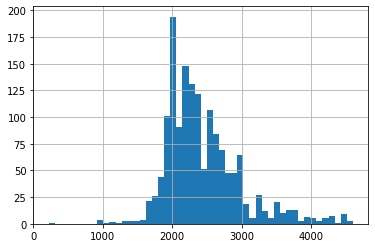

In [21]:
# Neighbourhood with the most listings is Waterfront Communities-The Island (77)
waterfront_prices = data_matrix[data_matrix['AREA_SHORT_CODE'] == 77]['Price']
mu, sigma = waterfront_prices.mean(), waterfront_prices.std()
waterfront_filtered = waterfront_prices[waterfront_prices < mu + 2*sigma]
waterfront_filtered.hist(bins=50)

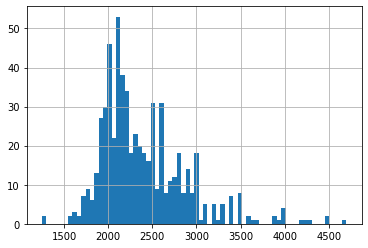

In [23]:
# Second is Bay Street Corridor (76)
bay_st_prices = data_matrix[data_matrix['AREA_SHORT_CODE'] == 76]['Price']
mu, sigma = bay_st_prices.mean(), bay_st_prices.std()
bay_st_filtered = bay_st_prices[bay_st_prices < mu + 2*sigma]
bay_st_filtered.hist(bins=70)

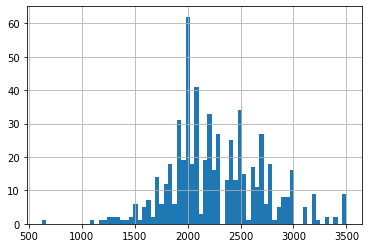

In [24]:
# Third is Church-Yonge Corridor (75)
cy_prices = data_matrix[data_matrix['AREA_SHORT_CODE'] == 75]['Price']
mu, sigma = cy_prices.mean(), cy_prices.std()
cy_filtered = cy_prices[cy_prices < mu + 2*sigma]
cy_filtered.hist(bins=70)

#### Price Distribution by Neighbourhood, Bedrooms

In [27]:
# Waterfront Communities-The Island (77)
data_matrix[data_matrix['AREA_SHORT_CODE'] == 77].groupby('Bedrooms').count()['lng']

Bedrooms
0.0     74
1.0    964
1.5      2
2.0    474
3.0     50
4.0      2
5.0      1
Name: lng, dtype: int64

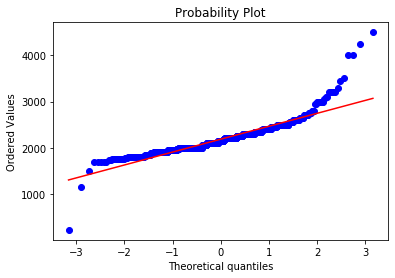

In [49]:
import pylab 
import scipy.stats as stats

waterfront = data_matrix[data_matrix['AREA_SHORT_CODE'] == 77]
mu, sigma = waterfront['Price'].mean(), waterfront['Price'].std()
waterfront = waterfront[waterfront['Price'] < mu + 2*sigma]

# 1 Bedroom, 1 Bathroom
waterfront_prices = waterfront[(waterfront['AREA_SHORT_CODE'] == 77) & (waterfront['Bedrooms'] == 1) & (waterfront['Bathrooms'] == 1)]['Price']
stats.probplot(waterfront_prices, dist="norm", plot=pylab)
pylab.show()

The QQ-plot indicates that the distribution of prices is more heavy-tailed (especially in the right tail) than that of a normal distrbution.

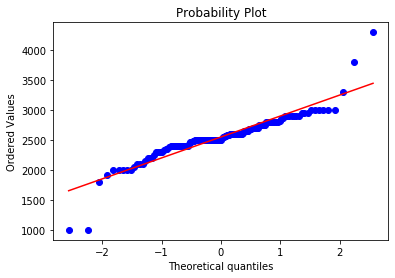

In [50]:
# 2 Bedroom, 1 Bathroom
waterfront_prices = waterfront[(waterfront['AREA_SHORT_CODE'] == 77) & (waterfront['Bedrooms'] == 2) & (waterfront['Bathrooms'] == 1)]['Price']
stats.probplot(waterfront_prices, dist="norm", plot=pylab)
pylab.show()

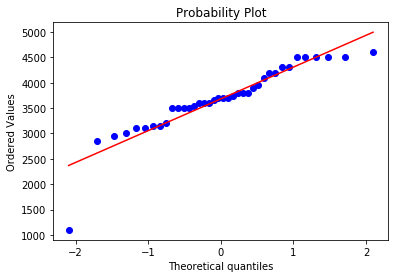

In [51]:
# 3 Bedroom, 1 Bathroom; a somewhat abnormal setting
waterfront_prices = waterfront[(waterfront['AREA_SHORT_CODE'] == 77) & (waterfront['Bedrooms'] == 3) & (waterfront['Bathrooms'] == 2)]['Price']
stats.probplot(waterfront_prices, dist="norm", plot=pylab)
pylab.show()

The QQ-plot suggests there might be some multi-modality (3), and again some heavy-tailedness.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4cdc36a90>,
      dtype=object)

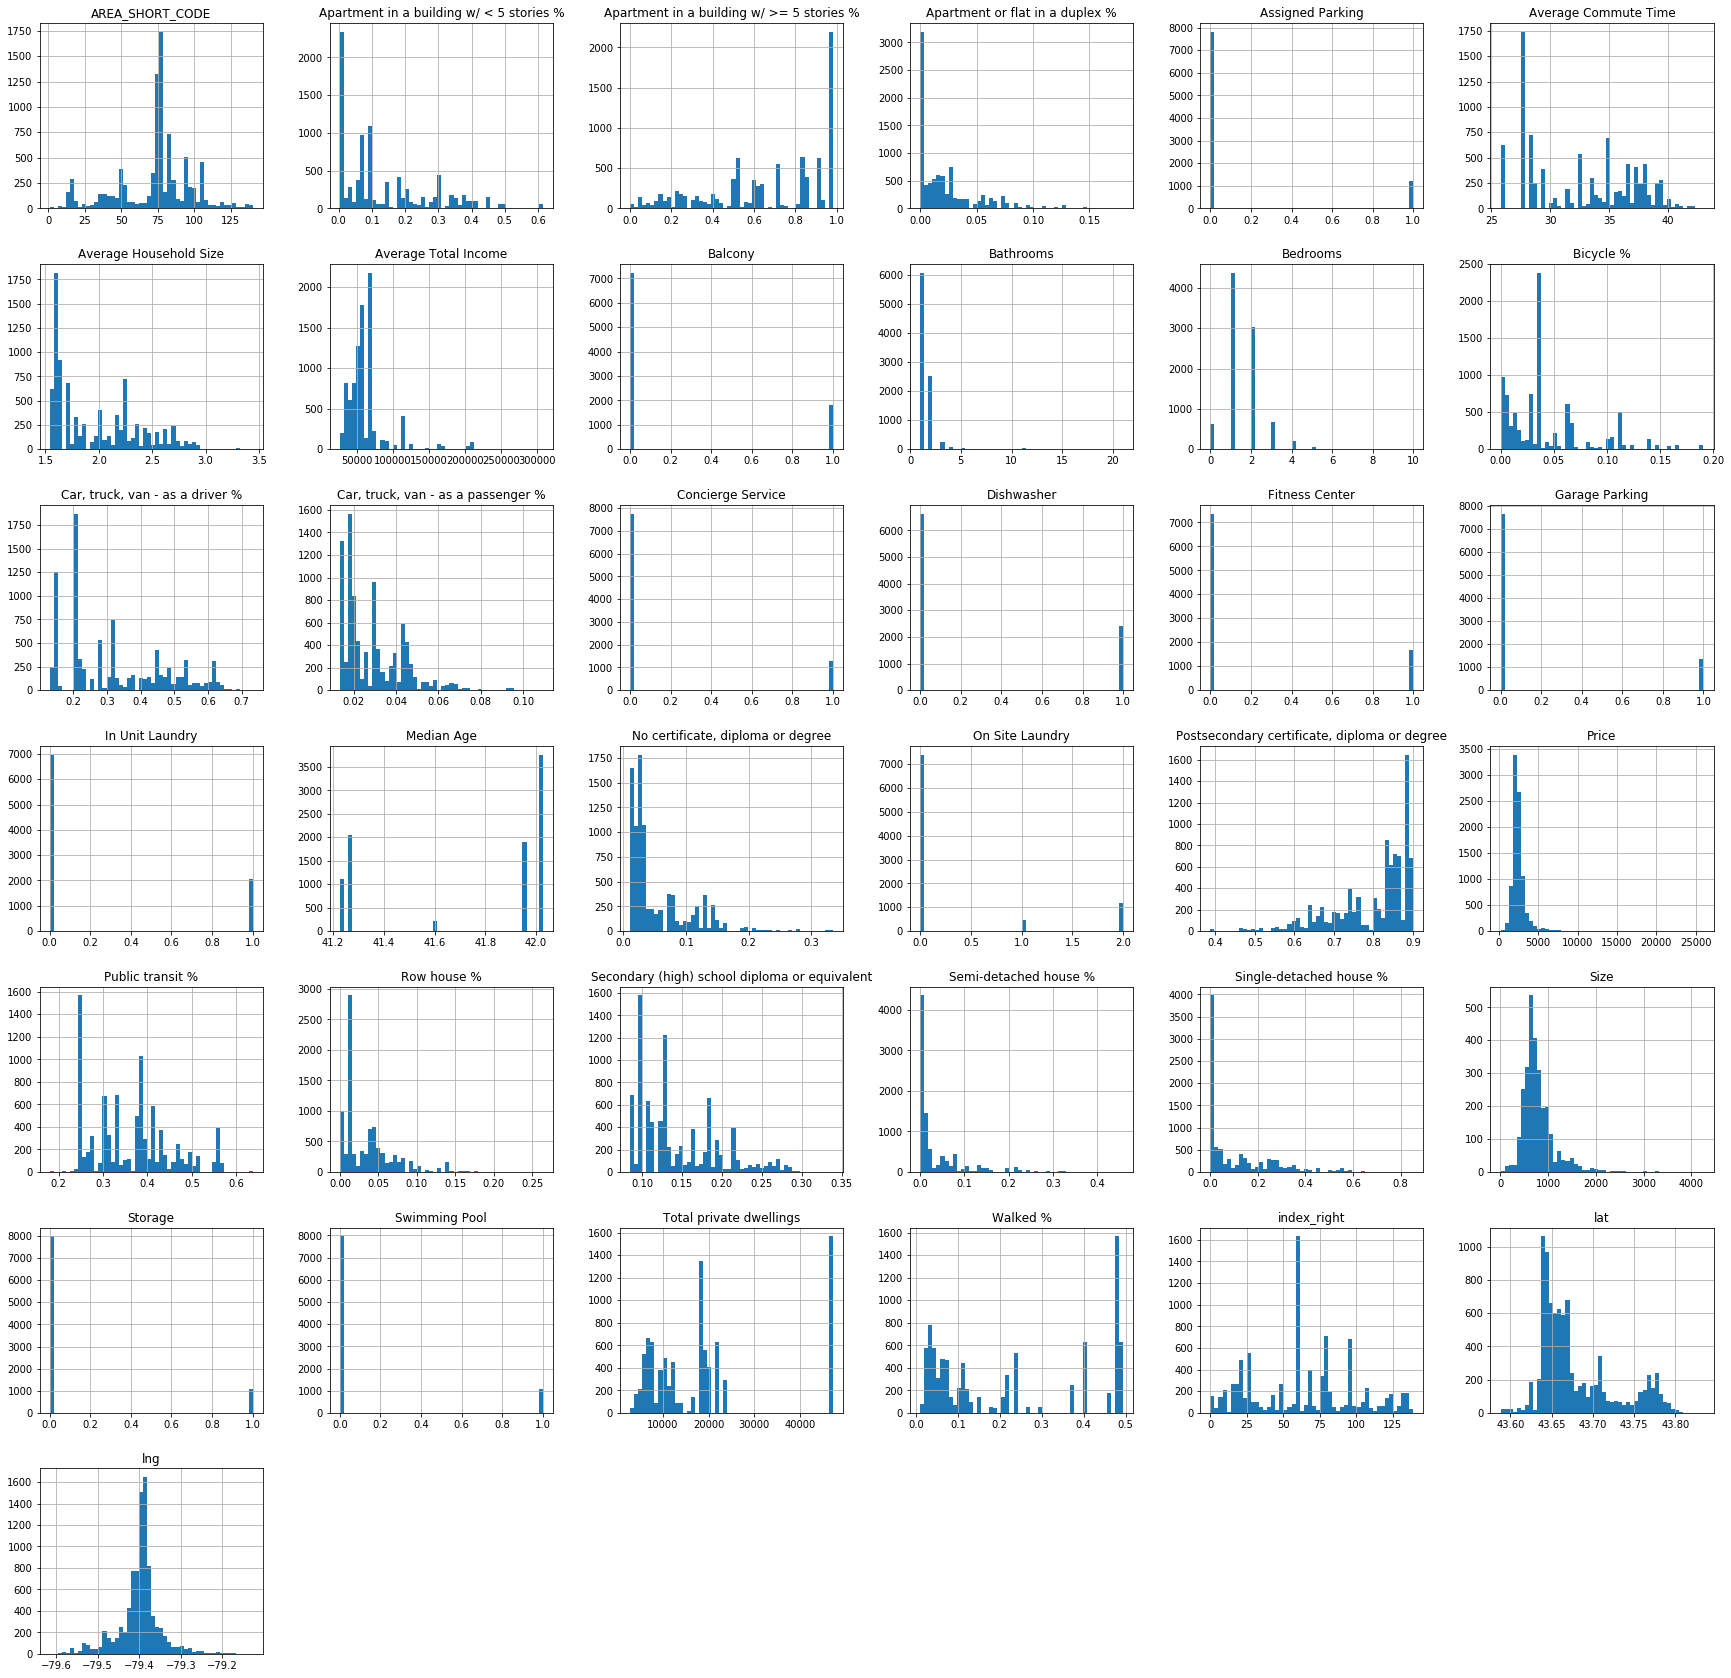

In [55]:
data_matrix.hist(bins=50, figsize=(30,30))

We can see that many of our histograms have a lot of skewness, amounting to the fact that many of the listings come from an areas with a specific demographic (e.g., university/college educated, has high population density, upper-middle class, etc.). This may make it difficult for our model to detect patterns in the populations which lie along the tails, resulting in sub-optimal predictions. We compare to the city-wide demographics:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4cd9f4f90>,
      dtype=object)

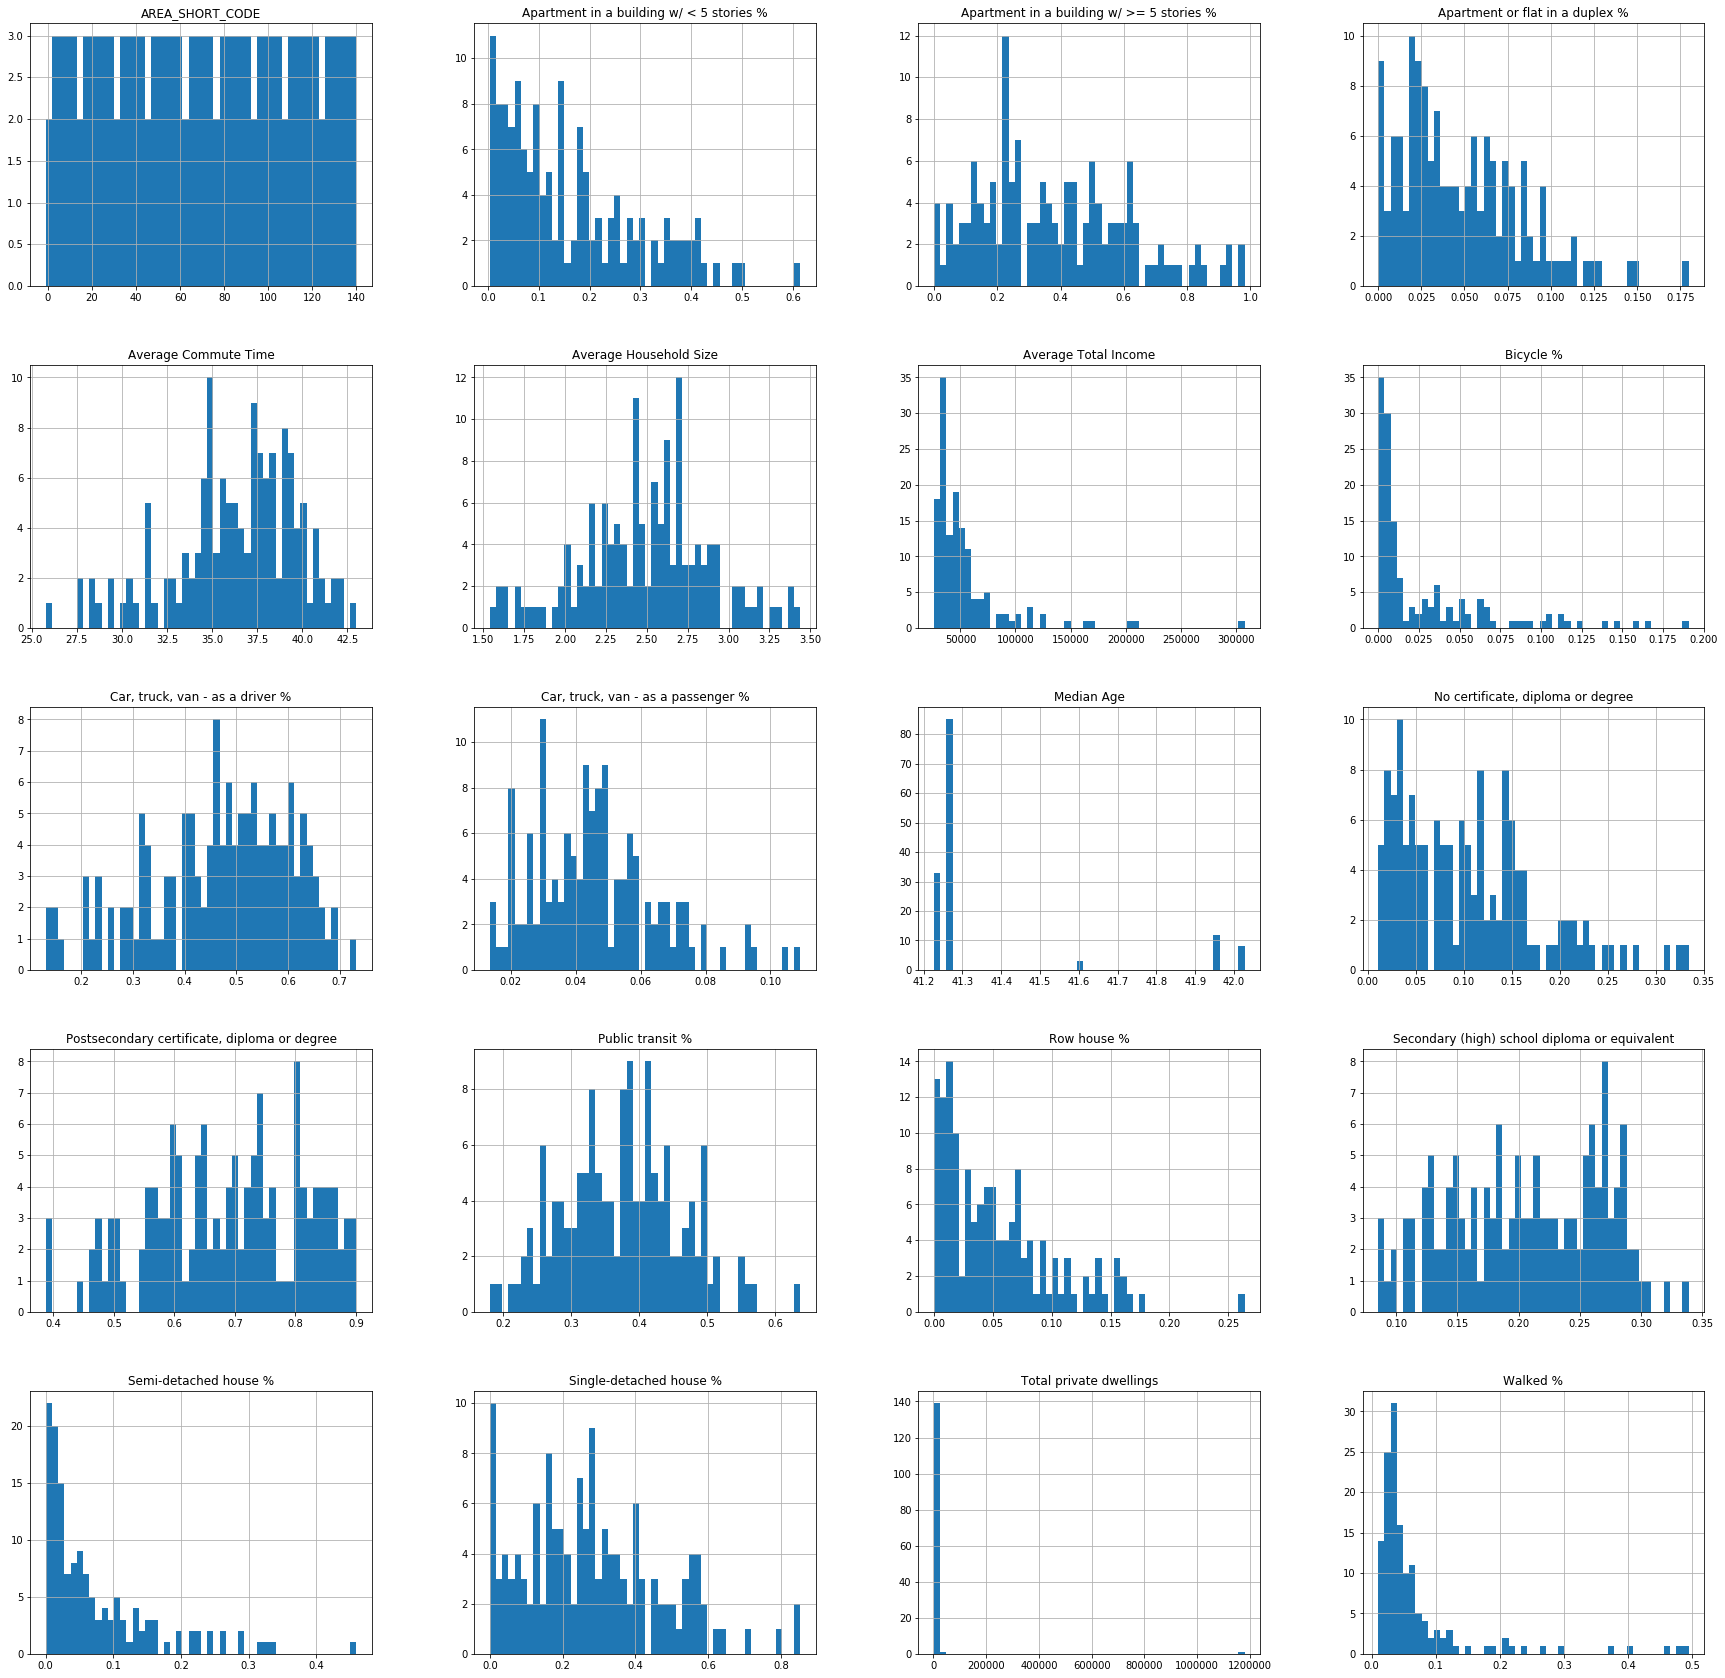

In [60]:
nbhd_profile_df.hist(bins=50, figsize=(30,30))

### **Train/Test Split**

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size=0.15, random_state=69)
for train_idx, test_idx in split.split(data_matrix, data_matrix[['AREA_SHORT_CODE']]):
    training_set = data_matrix.iloc[train_idx]
    test_set = data_matrix.iloc[test_idx]

We can check the coverage of our training set:

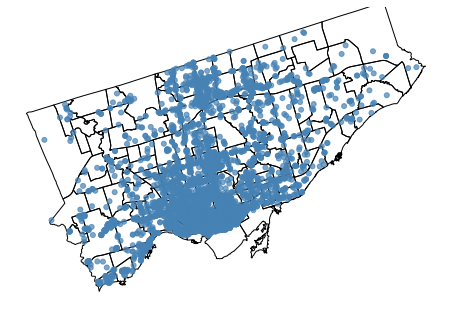

In [16]:
import geoplot


ax = geoplot.polyplot(nbhds_df['geometry'], projection=geoplot.crs.WebMercator())
geoplot.pointplot(training_set['geometry'], ax=ax, alpha=0.7)

In [17]:
corr_matrix = training_set.corr()
corr_matrix['Price'].sort_values(ascending=False)

Price                                            1.000000
Size                                             0.703283
Bedrooms                                         0.584033
Bathrooms                                        0.448912
Average Total Income                             0.177837
Postsecondary certificate, diploma or degree     0.120965
Single-detached house %                          0.077634
Bicycle %                                        0.032650
lat                                              0.030485
Car, truck, van - as a driver %                  0.025719
In Unit Laundry                                  0.022309
Average Household Size                           0.016627
Walked %                                         0.016563
Assigned Parking                                 0.015114
Apartment in a building w/ < 5 stories %         0.002541
Median Age                                       0.000539
Total private dwellings                          0.000271
Dishwasher    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6ce17ed90>,
      dtype=object)

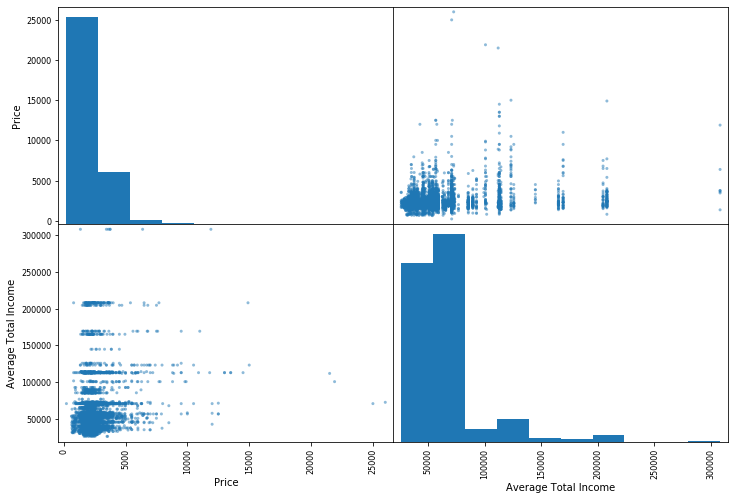

In [31]:
from pandas.plotting import scatter_matrix

# Check price against less correlated attributes (in case of non-linear relationships)
attributes = ['Price', 'Average Total Income']
scatter_matrix(training_set[attributes], figsize=(12, 8))

In [ ]:
# split the data in train a validation set 
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5) 
# base_model can be any regression model, a # sklearn.ensemble.GradientBoostingRegressor for instance 
base_model.fit(X1, y1) 
base_prediction = base_model.predict(X2) 
# compute the prediction error vector on the validation set 
validation_error = (base_prediction - y2) ** 2 
error_model.fit(X2, validation_error) 
# compute the mean and standard deviation of the distribution 
mean = base_model.predict(X_test) 
st_dev = error_model.predict(X_test)**0.5